# Comparisons 

This notebook is intended to help compare the pure absorber problem against the analytic solution.

In [4]:
import pickle
import numpy
from matplotlib import pyplot
from matplotlib.colors import Normalize
from fesnt import *
from analytic import pureAbsorberSoln

In [5]:
XLABEL = 'X [cm]'
TLABEL = 'Time [s]'
L2_NORM = '$l_2$ norm of error'
MU_FMT = r'$\mu={:7.5f}$'

In [6]:
pickleFile = 'example-pureAbsorber.yaml-7f785fd60b88.pickle'
with open(pickleFile, 'rb') as pickled:
    m = pickle.load(pickled)

## Helper functions

In [7]:
def getSolnMatrices(manager, pointsPerMesh=5):
    """Return FEM and analytic solutions"""
    angles = manager.angles
    fesoln, xgrid = manager.getFullMatrix(pointsPerMesh)
    trueSoln = numpy.empty_like(fesoln)
    timeGrid = manager.tgrid
    for muIndex, mu in enumerate(angles):
        truth = pureAbsorberSoln(mu, timeGrid, xgrid)
        trueSoln[:, muIndex, :] = truth.T
        
    return ((timeGrid, angles, xgrid), fesoln, trueSoln)

In [8]:
def makeRelDiff(fesoln, trueSoln, pointsPerMesh=5):
    """
    Return the relative difference analytic-FEM [%]
    
    Axes of array are [time, angle, space
    ]"""

    nonZeros = numpy.where(trueSoln != 0)
    relDiff = trueSoln - fesoln
    relDiff[nonZeros] /= trueSoln[nonZeros]
    return relDiff * 100

In [9]:
def plotError(x, t, matrix, title=None, norm=None, 
                           isRelative=True, isAbsolute=False, cmap=None):
    xm, tm = numpy.meshgrid(x, t)
    pyplot.pcolormesh(x, t, matrix, cmap=cmap, norm=norm)
    pyplot.xlabel(XLABEL)
    pyplot.ylabel(TLABEL)
    if title:
        pyplot.title(title)
    bar = pyplot.colorbar();
    label = 'Relative Difference [%]' if isRelative else 'Error'
    if isAbsolute:
        label = 'Absolute ' + label
    bar.set_label(label)

# Plot error over time

In [10]:
(tVec, muVec, xVec), femSoln, analyticSoln = getSolnMatrices(m)
relDiff = makeRelDiff(femSoln, analyticSoln)
xMesh, tMesh = numpy.meshgrid(xVec, tVec)

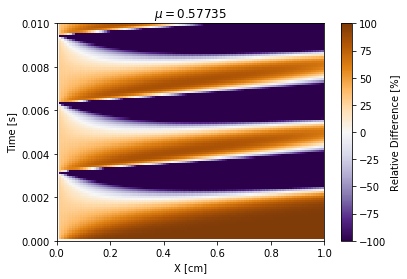

In [11]:
plotError(xVec, tVec, relDiff[:, 1, :], cmap='PuOr_r',
                  isRelative=True, title=MU_FMT.format(muVec[1]),
                  norm=Normalize(-100, 100))
pyplot.savefig('figures/mu2_relDiff_mesh')

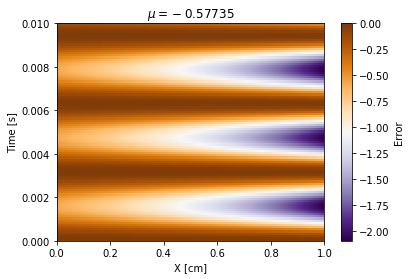

In [12]:
plotError(xVec, tVec, (analyticSoln - femSoln)[:, 0, :], cmap='PuOr_r',
                  isRelative=False, title=MU_FMT.format(muVec[0]))
pyplot.savefig('figures/mu1_error_mesh')

## In-depth error analysis

In [13]:
from numpy.linalg import norm

In [14]:
errorOverTime = norm(femSoln - analyticSoln, axis=2)

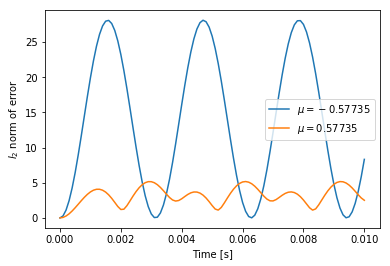

In [15]:
for muIndex, mu in enumerate(muVec):
    pyplot.plot(tVec, errorOverTime[:, muIndex], label=MU_FMT.format(mu))
pyplot.xlabel(TLABEL)
pyplot.ylabel(L2_NORM)
pyplot.legend();
pyplot.savefig('figures/error_time_allMu')